In [449]:
import tensorflow as tf
from tensorflow.keras import layers, models
import anndata
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min





# Assuming you have your gene expression data in 'X_train' (with cells as rows, genes as columns)







In [456]:

X_train = pd.read_csv('e17_expr.csv', index_col=0)
cell_labels = pd.read_csv('e17_labels.csv', index_col=0, header=None)
print(X_train)

         E17_5_AAACCTGAGCCAGAAC-1  E17_5_AAACCTGAGGCAATTA-1  \
Sox17                           0                         0   
Mrpl15                          0                         0   
Lypla1                          0                         0   
Tcea1                           0                         0   
Rgs20                           1                         0   
...                           ...                       ...   
Cldn16                          0                         0   
Stfa1                           0                         0   
Gm20683                         0                         0   
Ankrd1                          0                         0   
Sfrp5                           0                         0   

         E17_5_AAACCTGAGTGTCTCA-1  E17_5_AAACCTGCACATCCAA-1  \
Sox17                           0                         0   
Mrpl15                          1                         0   
Lypla1                          0                     

In [ ]:
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.metrics import normalized_mutual_info_score



def ari_loss(y_true, y_pred, cell_type_labels, cluster_labels, alpha=1):
    """
    Custom loss function that combines MSE (reconstruction) and ARI (clustering).
    """
    # Mean Squared Error (Reconstruction Loss)
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    mse_loss = keras.backend.mean(keras.backend.square(y_true - y_pred))
    
    # Adjusted Rand Index loss
    ari = adjusted_rand_score(cluster_labels, cell_type_labels)
    ari_loss = 1 - ari  # We want to maximize ARI, so minimize (1 - ARI)
    
    # Combined Loss
    total_loss = mse_loss + alpha * ari_loss
    return total_loss

def ami_loss(y_true, y_pred, cell_type_labels, cluster_labels, alpha=1):
    """
    Custom loss function that combines MSE (reconstruction) and AMI (clustering).
    """
    # Mean Squared Error (Reconstruction Loss)
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    mse_loss = keras.backend.mean(keras.backend.square(y_true - y_pred))
    
    # Adjusted Mutual Information loss
    ami = adjusted_mutual_info_score(cluster_labels, cell_type_labels)
    ami_loss = 1 - ami  # We want to maximize AMI, so minimize (1 - AMI)
    
    # Combined Loss
    total_loss = mse_loss + alpha * ami_loss
    return total_loss

def nmi_loss(y_true, y_pred, cell_type_labels, cluster_labels, alpha=1):
    """
    Custom loss function that combines MSE (reconstruction) and NMI (clustering).
    """
    # Mean Squared Error (Reconstruction Loss)
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    mse_loss = keras.backend.mean(keras.backend.square(y_true - y_pred))
    
    # Normalized Mutual Information loss
    nmi = normalized_mutual_info_score(cluster_labels, cell_type_labels)
    nmi_loss = 1 - nmi  # We want to maximize NMI, so minimize (1 - NMI)
    
    # Combined Loss
    total_loss = mse_loss + alpha * nmi_loss
    return total_loss



def build_autoencoder(input_dim, encoding_dim):
    # Encoder
    input_layer = layers.Input(shape=(input_dim,))
    encoded = layers.Dense(128, activation='relu')(input_layer)
    encoded = layers.Dense(encoding_dim, activation='relu')(encoded)

    # Decoder
    decoded = layers.Dense(128, activation='relu')(encoded)
    decoded = layers.Dense(input_dim, activation='sigmoid')(decoded)

    # Autoencoder
    autoencoder = models.Model(input_layer, decoded)
    
    # Encoder Model (to use for clustering)
    encoder = models.Model(input_layer, encoded)
    
    return autoencoder, encoder

In [460]:
class ARICallback(tf.keras.callbacks.Callback):
    def __init__(self, X_train, cell_labels_numeric, autoencoder, encoder):
        super(ARICallback, self).__init__()
        self.X_train = X_train
        self.cell_labels_numeric = cell_labels_numeric
        self.autoencoder = autoencoder
        self.encoder = encoder
        self.ari_values = []
        self.cluster_labels = []

    def on_epoch_end(self, epoch, logs=None):
        # Get the encoded data after this epoch
        encoded_data = self.encoder.predict(self.X_train)  # Get encoded data from the encoder network

        # Convert the encoded data to AnnData for Louvain clustering
        adata = sc.AnnData(encoded_data)
        sc.pp.pca(adata, n_comps=50)
        sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)
        sc.tl.louvain(adata)  # Run Louvain clustering on the encoded data
        
        self.cluster_labels = adata.obs['louvain']  # Extract cluster labels
        
        # Compute ARI
        ari_score = adjusted_rand_score(self.cell_labels_numeric, self.cluster_labels)
        
        # Store the ARI score
        self.ari_values.append(ari_score)

        # Optionally print ARI at every epoch
        print(f"Epoch {epoch+1}: ARI = {ari_score:.4f}")

    def plot_ari(self):
        # Plot ARI across epochs
        plt.plot(range(1, len(self.ari_values) + 1), self.ari_values)
        plt.xlabel('Epochs')
        plt.ylabel('ARI')
        plt.title('Adjusted Rand Index (ARI) through Epochs')
        plt.show()


class AMICallback(tf.keras.callbacks.Callback):
    def __init__(self, X_train, cell_labels_numeric, autoencoder, encoder):
        super(AMICallback, self).__init__()
        self.X_train = X_train
        self.cell_labels_numeric = cell_labels_numeric
        self.autoencoder = autoencoder
        self.encoder = encoder
        self.ami_values = []
        self.cluster_labels = []

    def on_epoch_end(self, epoch, logs=None):
        # Get the encoded data after this epoch
        encoded_data = self.encoder.predict(self.X_train)  # Get encoded data from the encoder network

        # Convert the encoded data to AnnData for Louvain clustering
        adata = sc.AnnData(encoded_data)
        sc.pp.pca(adata, n_comps=50)
        sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)
        sc.tl.louvain(adata)  # Run Louvain clustering on the encoded data
        
        self.cluster_labels = adata.obs['louvain']  # Extract cluster labels
        
        # Compute ARI
        ami_score = adjusted_mutual_info_score(self.cell_labels_numeric, self.cluster_labels)
        
        # Store the ARI score
        self.ami_values.append(ami_score)

        # Optionally print ARI at every epoch
        print(f"Epoch {epoch+1}: AMI = {ami_score:.4f}")

    def plot_ami(self):
        # Plot ARI across epochs
        plt.plot(range(1, len(self.ami_values) + 1), self.ami_values)
        plt.xlabel('Epochs')
        plt.ylabel('AMI')
        plt.title('AMI through Epochs')
        plt.show()


class NMICallBack(tf.keras.callbacks.Callback):
    def __init__(self, X_train, cell_labels_numeric, autoencoder, encoder):
        super(NMICallBack, self).__init__()
        self.X_train = X_train
        self.cell_labels_numeric = cell_labels_numeric
        self.autoencoder = autoencoder
        self.encoder = encoder
        self.nmi_values = []
        self.cluster_labels = []

    def on_epoch_end(self, epoch, logs=None):
        # Get the encoded data after this epoch
        encoded_data = self.encoder.predict(self.X_train)  # Get encoded data from the encoder network

        # Convert the encoded data to AnnData for Louvain clustering
        adata = sc.AnnData(encoded_data)
        sc.pp.pca(adata, n_comps=50)
        sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)
        sc.tl.louvain(adata)  # Run Louvain clustering on the encoded data
        
        self.cluster_labels = adata.obs['louvain']  # Extract cluster labels
        
        # Compute ARI
        nmi_score = adjusted_mutual_info_score(self.cell_labels_numeric, self.cluster_labels)
        
        # Store the ARI score
        self.nmi_values.append(nmi_score)

        # Optionally print ARI at every epoch
        print(f"Epoch {epoch+1}: NMI = {nmi_score:.4f}")

    def plot_nmi(self):
        # Plot ARI across epochs
        plt.plot(range(1, len(self.nmi_values) + 1), self.nmi_values)
        plt.xlabel('Epochs')
        plt.ylabel('NMI')
        plt.title('NMI through Epochs')
        plt.show()


In [458]:
from sklearn.mixture import GaussianMixture
from keras.callbacks import EarlyStopping
import scanpy as sc

scaler = StandardScaler()
X_train = X_train.T
input_dim = X_train.shape[1]
encoding_dim = 200  # You can adjust this based on your data

# Build the autoencoder model as before
autoencoder, encoder = build_autoencoder(input_dim, encoding_dim)

# Use K-means to initialize the Zcluster labels

encoded_data = encoder.predict(X_train)
adata = sc.AnnData(X_train)
sc.pp.pca(adata, n_comps=50)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)
sc.tl.louvain(adata) 
# Train the model with the combined loss
#autoencoder.compile(optimizer='adam', loss=lambda y_true, y_pred: clustering_loss(y_true, y_pred, encoded_data, cluster_labels, 14))
cluster_labels = adata.obs['louvain'].astype(int)

cell_type_counts = cell_labels.value_counts()
sorted_cell_types = cell_type_counts.sort_values(ascending=False)
print("GT: ", sorted_cell_types)
# Ensure cluster_labels is a Pandas Series
sorted_cluster_labels = pd.Series(cluster_labels).value_counts().sort_values(ascending=False)
print("Prediction", sorted_cluster_labels)
cell_type_to_numeric = {cell_type: idx for idx, cell_type in enumerate(sorted_cell_types.index)}

cell_type_to_numeric = {key[0]: value for key, value in cell_type_to_numeric.items()}
print(cell_type_to_numeric)




147/147 [==============================] - 1s 6ms/step
GT:  1                       
UL CPN                      963
Migrating neurons           852
Interneurons                783
DL CPN                      486
Layer 4                     412
CThPN                       392
Astrocytes                  294
SCPN                        164
Cycling glial cells         147
Intermediate progenitors    130
Oligodendrocytes             33
Cajal Retzius cells          17
Endothelial cells             9
Microglia                     8
Name: count, dtype: int64
Prediction louvain
0     902
1     686
2     568
3     487
4     450
5     340
6     294
7     286
8     247
9     139
10    123
11     83
12     48
13     37
Name: count, dtype: int64
{'UL CPN': 0, 'Migrating neurons': 1, 'Interneurons': 2, 'DL CPN': 3, 'Layer 4': 4, 'CThPN': 5, 'Astrocytes': 6, 'SCPN': 7, 'Cycling glial cells': 8, 'Intermediate progenitors': 9, 'Oligodendrocytes': 10, 'Cajal Retzius cells': 11, 'Endothelial cells': 12,

In [ ]:
cluster_mapping = {}
cell_labels_numeric = cell_labels.iloc[:,0].map(cell_type_to_numeric)
sorted_cell_types = cell_labels_numeric.value_counts().sort_values(ascending=False)
for i, predicted_cluster in enumerate(sorted_cluster_labels.index):
    # Find the ground truth label with the same rank (based on the size of clusters)
    matching_gt_cluster = sorted_cell_types.index[i]
    cluster_mapping[predicted_cluster] = matching_gt_cluster
print(cluster_mapping)
mapped_cluster_labels = np.array([cluster_mapping[label] for label in cluster_labels])

IndexError: index 14 is out of bounds for axis 0 with size 14

In [459]:
import keras
import tensorflow as tf
from sklearn.metrics import adjusted_rand_score
from keras import layers, models
from sklearn.mixture import GaussianMixture
import numpy as np


early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
nmi_callback = NMICallback(X_train, cell_labels_numeric, autoencoder=autoencoder, encoder=encoder)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
autoencoder.compile(optimizer='adam', loss=lambda y_true, y_pred: nmi_loss(y_true, y_pred, cell_labels_numeric, cluster_labels))

autoencoder.fit(X_train, X_train, epochs=100, batch_size=256, shuffle=True, callbacks=[nmi_callback, early_stopping])
nmi_callback.plot_nmi()



NameError: name 'NMICallback' is not defined

Best number of clusters: 10 with silhouette score: -0.007004777435213327


Number of clusters adjusted to match the ground truth cell types (14).


In [111]:
print(kmeans)

KMeans(n_clusters=14, random_state=42)


GT:  1                       
UL CPN                      963
Migrating neurons           852
Interneurons                783
DL CPN                      486
Layer 4                     412
CThPN                       392
Astrocytes                  294
SCPN                        164
Cycling glial cells         147
Intermediate progenitors    130
Oligodendrocytes             33
Cajal Retzius cells          17
Endothelial cells             9
Microglia                     8
Name: count, dtype: int64
Prediction 7     1576
1     1150
13     648
10     200
3      134
2      130
11     130
8      114
0      109
4      106
12     105
5      102
9       95
6       91
Name: count, dtype: int64
{'UL CPN': 0, 'Migrating neurons': 1, 'Interneurons': 2, 'DL CPN': 3, 'Layer 4': 4, 'CThPN': 5, 'Astrocytes': 6, 'SCPN': 7, 'Cycling glial cells': 8, 'Intermediate progenitors': 9, 'Oligodendrocytes': 10, 'Cajal Retzius cells': 11, 'Endothelial cells': 12, 'Microglia': 13}


In [402]:

ari_score = adjusted_rand_score(ari_callback.cell_labels_numeric, ari_callback.cluster_labels)
print(f"Adjusted Rand Index: {ari_score}")

Adjusted Rand Index: 0.5376476937619196


c:\Users\jccarado\keras-retinanet\myenv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[0 1 2 3 4 5 6 7 8 9]


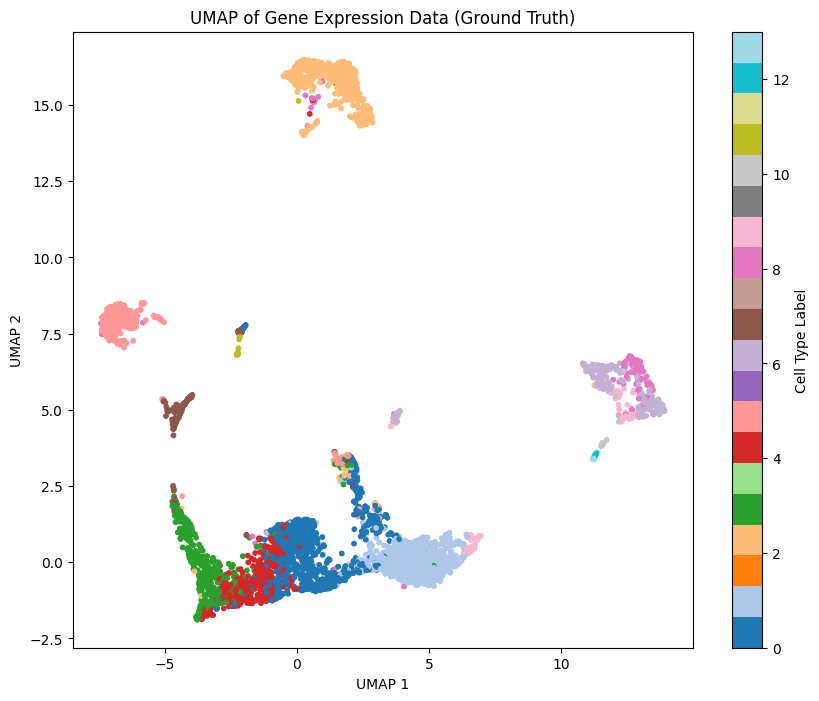

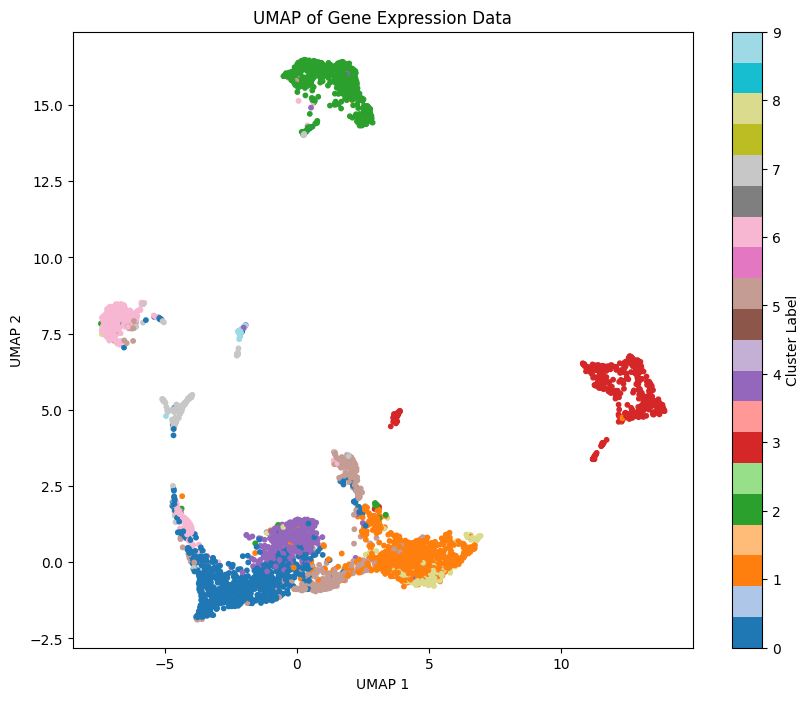

In [455]:
import umap
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder


pca = PCA(n_components=50)  # You can change this value as needed
X_pca = pca.fit_transform(X_train)

umap_model = umap.UMAP(n_components=2)  # We want to reduce it to 2D for visualization
X_umap = umap_model.fit_transform(X_pca)
cluster_labels = ami_callback.cluster_labels
cluster_labels = cluster_labels.astype('category').cat.codes
print(np.unique(cluster_labels))
# Step 4: Visualize the UMAP projection
plt.figure(figsize=(10, 8))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=cell_labels_numeric, cmap='tab20', s=10)
plt.title('UMAP of Gene Expression Data (Ground Truth)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.colorbar(label='Cell Type Label')
plt.figure(figsize=(10, 8))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c= cluster_labels, cmap='tab20', s=10)
plt.title('UMAP of Gene Expression Data')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.colorbar(label='Cluster Label')
plt.show()

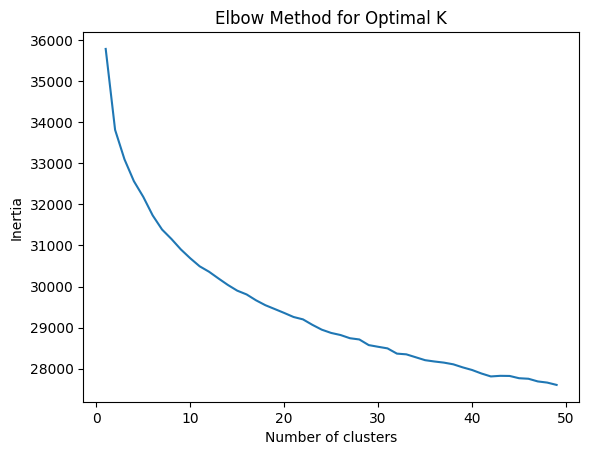

In [308]:

inertias = []
for n in range(1, 50):  # Try values from 1 to 20
    kmeans = KMeans(n_clusters=n, random_state=42)
    kmeans.fit(encoded_data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1, 50), inertias)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()


ValueError: too many values to unpack (expected 2)

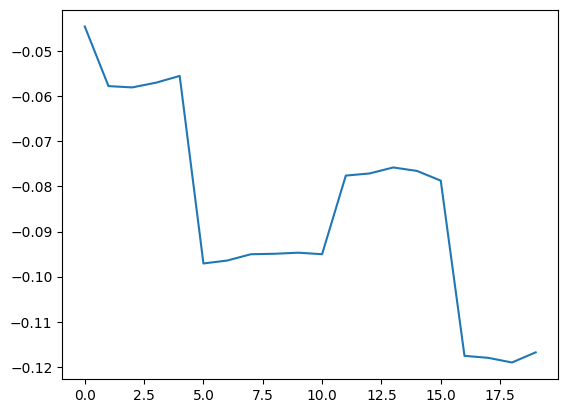

In [ ]:
silhouette_scores = []
for n in np.arange(0.1, 2.1, 0.1):  # test only from 5 to 15
    sc.tl.louvain(adata, resolution=n) 
    cluster_labels = adata.obs['louvain'].astype(int) 
    silhouette_scores.append(silhouette_score(X_train, cluster_labels))





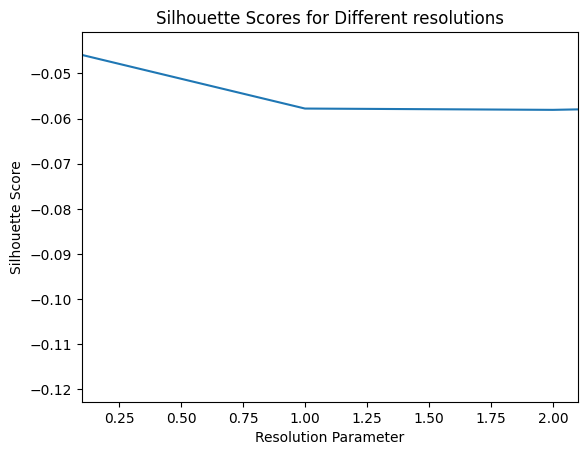

[-0.04456045265157051, -0.05777467469548003, -0.05806381567943037, -0.0570164629356897, -0.05551755056752821, -0.09707730323234497, -0.09643096550254393, -0.09503462227944978, -0.09492910520259457, -0.09469052950506848, -0.09502970820757418, -0.0776027810423989, -0.07713369133098834, -0.07580180732171923, -0.07657636372760518, -0.07872461508179715, -0.11755055445857801, -0.11799246426116707, -0.11902102856264991, -0.1167767521569091]


In [321]:
plt.plot(silhouette_scores)
plt.xlim(0.1,2.1)
plt.xlabel('Resolution Parameter')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different resolutions')
plt.show()

print(silhouette_scores)